<a href="https://colab.research.google.com/github/anniepeacock/DANSAR/blob/devel/burn_severity/PostFire_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SAR & NDVI Regeneration Post-Fire**

*Post-Fire comparison of NDVI and SAR*


Google Earth Engine code of NDVI time series in SAR burn severity classes:

https://code.earthengine.google.com/718ef671127dfab9a40b75590a1fa855

UAVSAR Data Staging Area: https://uavsar.jpl.nasa.gov/cgi-bin/sar-notebooks.pl

* can print time series, but times out with too much data
* can instead export to Google Drive a csv of the time series
* currently these are assets on GEE, that can be used for the time series.
  * UAVSAR severity classes: projects/wetlands-366023/assets/uavsar_severity
  * UAVSAR & dNBR agreement classes: uavsar_dnbr_agreement
  * UAVSAR & dNBR disagreement classes: disagree_sar_dnbr
  * BAER severity classes: projects/wetlands-366023/assets/BAER_severity
  * MTBS severity classes: projects/wetlands-366023/assets/MTBS_severity


In [1]:
!pip install rasterio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 28.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from rasterio.features import shapes
from shapely.geometry import shape

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Read in CSVs that were generated from Google Earth (NDVI and NBR mean and standard deviation per class as monthly composites)
columns_to_read = ['NDVI', 'STDEV', 'NBR', 'NBR_STDEV', 'VALUE', 'date']

# CSV file path in Google Drive
baer_path = '/content/drive/MyDrive/UAVSAR_Science/LaTuna_Fire/Scripts/csvs/monthly_ndvi_nbr_composite_baer_severity_classes.csv'
baer_df = pd.read_csv(baer_path, usecols=columns_to_read)

mtbs_path = '/content/drive/MyDrive/UAVSAR_Science/LaTuna_Fire/Scripts/csvs/monthly_ndvi_nbr_composite_mtbs_severity_classes.csv'
mtbs_df = pd.read_csv(mtbs_path, usecols=columns_to_read)

uavsar_path = '/content/drive/MyDrive/UAVSAR_Science/LaTuna_Fire/Scripts/csvs/monthly_ndvi_nbr_composite_uavsar_severity_classes.csv'
uavsar_df = pd.read_csv(uavsar_path, usecols=columns_to_read)

dnbr_uavsar_agree_path = '/content/drive/MyDrive/UAVSAR_Science/LaTuna_Fire/Scripts/csvs/monthly_ndvi_nbr_composite_uavsar_dnbr_agree.csv'
dnbr_uavsar_agree_df = pd.read_csv(dnbr_uavsar_agree_path, usecols=columns_to_read)

dnbr_uavsar_disagree_path = '/content/drive/MyDrive/UAVSAR_Science/LaTuna_Fire/Scripts/csvs/monthly_ndvi_nbr_composite_uavsar_dnbr_disagree.csv'
dnbr_uavsar_disagree_df = pd.read_csv(dnbr_uavsar_disagree_path, usecols=columns_to_read)

calveg_path = '/content/drive/MyDrive/UAVSAR_Science/LaTuna_Fire/Scripts/csvs/monthly_ndvi_nbr_composite_calveg.csv'
calveg_df = pd.read_csv(calveg_path, usecols=columns_to_read)

dnbr_uavsar_disagree_df

NDVI     STDEV       NBR  NBR_STDEV  VALUE                 date
0    0.248268  0.108478  0.279349   0.138748   10.0  2016-01-01T00:00:00
1    0.197277  0.119979  0.120979   0.170604   60.0  2016-01-01T00:00:00
2    0.204964  0.144266  0.316390   0.143733   40.0  2016-01-01T00:00:00
3    0.228583  0.096290  0.068479   0.137748   30.0  2016-01-01T00:00:00
4    0.362248  0.061798  0.287123   0.102109   10.0  2016-02-01T00:00:00
..        ...       ...       ...        ...    ...                  ...
375  0.182622  0.045790  0.104454   0.054370   30.0  2023-11-23T00:00:00
376  0.131912  0.064064  0.143625   0.057187   10.0  2023-12-24T00:00:00
377  0.166036  0.086976  0.119123   0.075957   60.0  2023-12-24T00:00:00
378  0.104445  0.076055  0.138598   0.057546   40.0  2023-12-24T00:00:00
379  0.170841  0.057817  0.099601   0.065195   30.0  2023-12-24T00:00:00

[380 rows x 6 columns]

In [5]:
a = calveg_df['VALUE'].unique()
a

array(['SUMAC SHRUB ALLIANCE', 'URBAN-RELATED BARE SOIL',
       'ANNUAL GRASSES AND FORBS ALLIANCE',
       'LOWER MONTANE MIXED CHAPARRAL ALLIANCE', 'EUCALYPTUS ALLIANCE',
       'SOFT SCRUB - MIXED CHAPARRAL ALLIANCE',
       'CEANOTHUS CHAPARRAL ALLIANCE', 'SCRUB OAK ALLIANCE',
       'CALIFORNIA BAY ALLIANCE', 'BUCKWHEAT ALLIANCE',
       'CALIFORNIA SAGEBRUSH ALLIANCE', 'BIGCONE DOUGLAS-FIR ALLIANCE',
       'COASTAL MIXED HARDWOOD ALLIANCE', 'COAST LIVE OAK ALLIANCE',
       'Barren'], dtype=object)

## Sentinel-2 Time Series

In [6]:
# from matplotlib import colormaps
# list(colormaps)

In [7]:
import ee
import geemap

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='wetlands-366023')

In [8]:
# Define the polygon assets on GEE
asset1 = ee.FeatureCollection('projects/wetlands-366023/assets/uavsar_severity')
asset2 = ee.FeatureCollection('projects/wetlands-366023/assets/calveg_verdugos')
asset3 = ee.FeatureCollection('projects/wetlands-366023/assets/disagree_sar_dnbr')
asset4 = ee.FeatureCollection('projects/wetlands-366023/assets/uavsar_dnbr_agreement_classes')

# Export the asset as GeoJSON to use in notebook
output_path = 'uavsar_severity.geojson'  # Change this to your desired output path
geemap.ee_export_vector(asset1, filename=output_path)

output_path2 = 'calveg_verdugos.geojson'
geemap.ee_export_vector(asset2, filename=output_path2)

output_path3 = 'disagree_sar_dnbr.geojson'
geemap.ee_export_vector(asset3, filename=output_path3)

output_path4 = 'uavsar_dnbr_agreement_classes.geojson'
geemap.ee_export_vector(asset4, filename=output_path4)

Generating URL ...
Please wait ...
Data downloaded to /content/uavsar_severity.geojson
Generating URL ...
Please wait ...
Data downloaded to /content/calveg_verdugos.geojson
Generating URL ...
Please wait ...
Data downloaded to /content/disagree_sar_dnbr.geojson
Generating URL ...
Please wait ...
Data downloaded to /content/uavsar_dnbr_agreement_classes.geojson


## Examining how UAVSAR-derived Fire Severity Class and CalVeg Association Overlap

In [34]:
# Read the GeoJSON files into GeoDataFrames
geojson1 = 'uavsar_severity.geojson'
geojson2 = 'calveg_verdugos.geojson'

gdf1 = gpd.read_file(geojson1)
gdf2 = gpd.read_file(geojson2)

# Reproject geometries to a projected CRS
gdf1 = gdf1.to_crs('EPSG:3395')  # Choose an appropriate projected CRS
gdf2 = gdf2.to_crs('EPSG:3395')  # Choose the same CRS as gdf1

# Perform a spatial join to find overlapping geometries
intersected = gpd.overlay(gdf1, gdf2, how='intersection', keep_geom_type=False)

# Calculate the area of overlap for each attribute combination
intersected['overlap_area'] = intersected.geometry.area

# Calculate the total area of each attribute in gdf1
total_area_gdf1 = gdf1.groupby('VALUE')['geometry'].apply(lambda x: x.unary_union.area).reset_index()

# Calculate the percentage of overlap for each attribute combination
result = intersected.groupby(['VALUE', 'REG_DOMINA'])['overlap_area'].sum().reset_index()
total_area = result['overlap_area'].sum()

area_per_class = result.groupby('VALUE').sum()['overlap_area']
result = result.merge(area_per_class, left_on='VALUE', right_on='VALUE')
result['percentage_overlap'] = (result['overlap_area_x'] / result['overlap_area_y']) * 100

result.head()

VALUE                         REG_DOMINA  overlap_area_x  overlap_area_y  \
0   10.0  ANNUAL GRASSES AND FORBS ALLIANCE    1.672652e+05    1.112024e+07   
1   10.0                 BUCKWHEAT ALLIANCE    2.018948e+04    1.112024e+07   
2   10.0                             Barren    1.327461e+05    1.112024e+07   
3   10.0      CALIFORNIA SAGEBRUSH ALLIANCE    1.384576e+06    1.112024e+07   
4   10.0       CEANOTHUS CHAPARRAL ALLIANCE    1.981207e+05    1.112024e+07   

   percentage_overlap  
0            1.504152  
1            0.181556  
2            1.193734  
3           12.450958  
4            1.781623

In [35]:
each_veg_area = result.groupby('REG_DOMINA')

In [36]:
# Group by VALUE and REG_DOMINA, then sum the overlap_area
df = result
grouped = df.groupby(['VALUE', 'REG_DOMINA'])['percentage_overlap'].sum().unstack()
grouped

REG_DOMINA  ANNUAL GRASSES AND FORBS ALLIANCE  BUCKWHEAT ALLIANCE    Barren  \
VALUE                                                                         
10.0                                 1.504152            0.181556  1.193734   
20.0                                 0.204130            0.003971  0.170282   
30.0                                 0.019771                 NaN  0.002229   

REG_DOMINA  CALIFORNIA SAGEBRUSH ALLIANCE  CEANOTHUS CHAPARRAL ALLIANCE  \
VALUE                                                                     
10.0                            12.450958                      1.781623   
20.0                            24.221988                      1.279152   
30.0                            30.589817                      0.485955   

REG_DOMINA  COAST LIVE OAK ALLIANCE  COASTAL MIXED HARDWOOD ALLIANCE  \
VALUE                                                                  
10.0                       1.155386                         2.962676   
20.0                       0.254597                         1.270601   
30.0                       0.012233                         0.083589   

REG_DOMINA  LOWER MONTANE MIXED CHAPARRAL ALLIANCE  SCRUB OAK ALLIANCE  \
VALUE                                                                    
10.0                                     17.961089            1.634522   
20.0                                     24.672792            1.143434   
30.0                                     29.932315            0.477884   

REG_DOMINA  SOFT SCRUB - MIXED CHAPARRAL ALLIANCE  SUMAC SHRUB ALLIANCE  \
VALUE                                                                     
10.0                                     4.838528             52.488012   
20.0                                     4.503232             41.322160   
30.0                                     2.313621             35.756127   

REG_DOMINA  URBAN-RELATED BARE SOIL  
VALUE                                
10.0                       1.847764  
20.0                       0.953661  
30.0                       0.326460

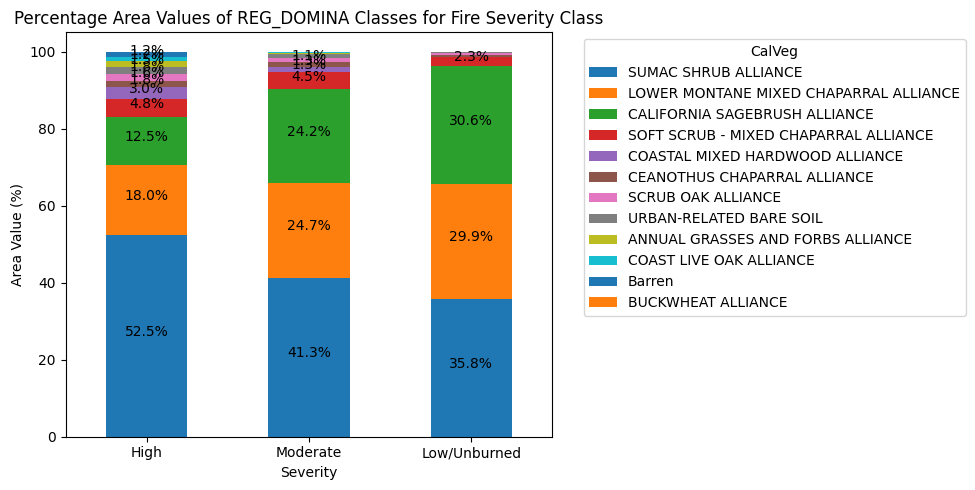

In [37]:
#@title CalVeg Bar Chart

# Group by VALUE and REG_DOMINA, then sum the percentage_overlap
grouped = df.groupby(['VALUE', 'REG_DOMINA'])['percentage_overlap'].sum().unstack()

# Calculate the sum of percentage_overlap within each REG_DOMINA
sums_by_reg_domina = grouped.sum(axis=0)

# Sort the REG_DOMINA categories based on the sums
sorted_reg_domina = sums_by_reg_domina.sort_values(ascending=False).index

# Reindex the DataFrame based on the sorted REG_DOMINA categories
grouped_sorted = grouped[sorted_reg_domina]

# Plotting
ax = grouped_sorted.plot(kind='bar', stacked=True, figsize=(10, 5))

# Adding labels and title
plt.title('Percentage Area Values of REG_DOMINA Classes for Fire Severity Class')
plt.xlabel('Severity')
plt.ylabel('Area Value (%)')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.xticks([0, 1, 2], ["High", "Moderate", "Low/Unburned"]) # 10=High, 20=Moderate, 30=Low/Unburned
# bigger legend - put outside plot
plt.legend(title='CalVeg', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adding value labels on top of each bar (only if height > 1), comment out to get rid of labels
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 1:
        ax.annotate(f'{height:.1f}%', (x + width/2, y + height*0.5), ha='center')

# Show plot
plt.tight_layout()
plt.show()

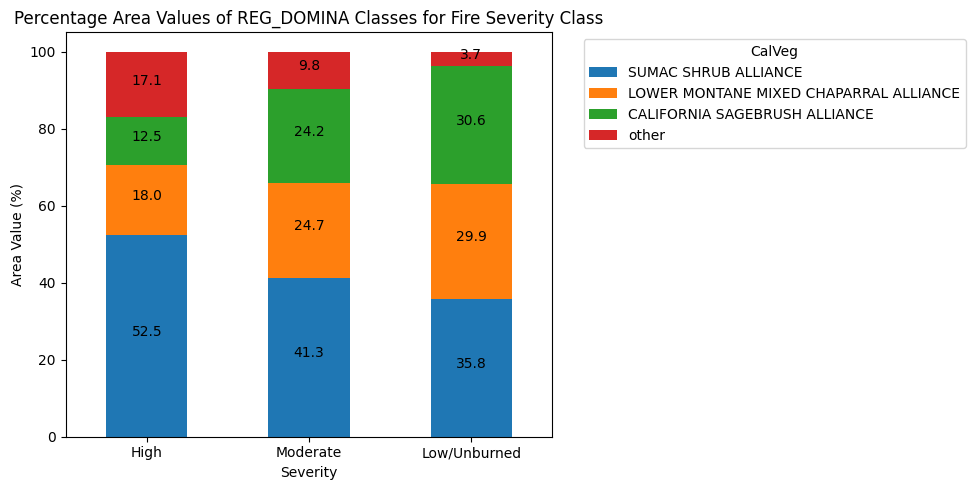

In [13]:
#@title Classes Grouped

# Define which REG_DOMINA categories to group into 'other'
other_categories = ['BUCKWHEAT ALLIANCE', 'Barren','COAST LIVE OAK ALLIANCE','ANNUAL GRASSES AND FORBS ALLIANCE','URBAN-RELATED BARE SOIL',
                    'SCRUB OAK ALLIANCE','CEANOTHUS CHAPARRAL ALLIANCE','COASTAL MIXED HARDWOOD ALLIANCE','SOFT SCRUB - MIXED CHAPARRAL ALLIANCE']  # categories to be grouped into 'other'

# Group by VALUE and REG_DOMINA, then sum the percentage_overlap
grouped = df.groupby(['VALUE', 'REG_DOMINA'])['percentage_overlap'].sum().unstack()

# Create 'other' category by summing specified categories
grouped['other'] = grouped[other_categories].sum(axis=1)

# Drop the original categories that were grouped into 'other'
grouped = grouped.drop(columns=other_categories)

# Calculate the sum of percentage_overlap within each REG_DOMINA
sums_by_reg_domina = grouped.sum(axis=0)

# Sort the REG_DOMINA categories based on the sums
sorted_reg_domina = sums_by_reg_domina.sort_values(ascending=False).index

# Reindex the DataFrame based on the sorted REG_DOMINA categories
grouped_sorted = grouped[sorted_reg_domina]

# Plotting
ax = grouped_sorted.plot(kind='bar', stacked=True, figsize=(10, 5))

# Adding labels and title
plt.title('Percentage Area Values of REG_DOMINA Classes for Fire Severity Class')
plt.xlabel('Severity')
plt.ylabel('Area Value (%)')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.xticks([0, 1, 2], ["High", "Moderate", "Low/Unburned"]) # 10=High, 20=Moderate, 30=Low/Unburned
# bigger legend - put outside plot
plt.legend(title='CalVeg', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adding value labels on top of each bar (only if height > 1), comment out to get rid of labels
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 1:
        ax.annotate(f'{height:.1f}', (x + width/2, y + height*0.5), ha='center')

# Show plot
plt.tight_layout()
plt.show()

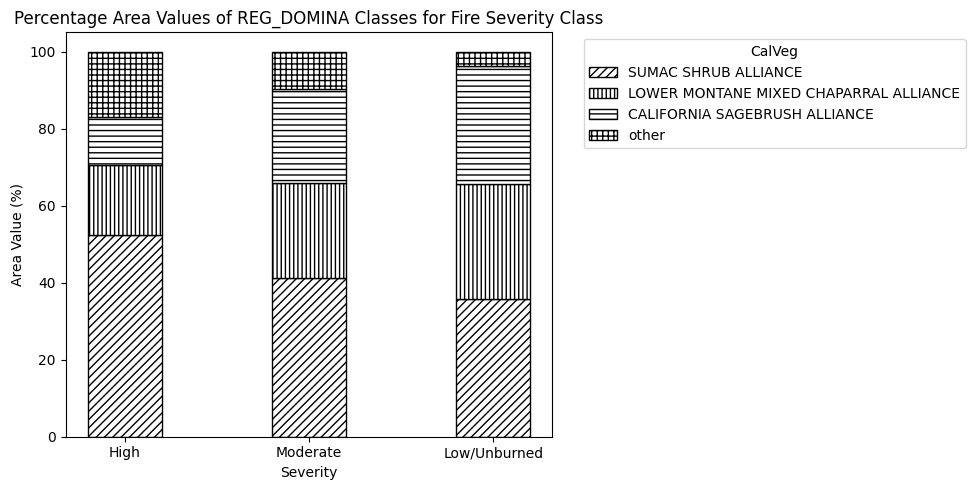

In [14]:
#@title CalVeg Bar Chart (Black & White)

# Define hatch patterns
hatch_patterns = ['////', '||||', '---', '+++', 'xxx', 'ooo', 'OOO', '...', '***']

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

# Define the number of bars
n_bars = len(grouped_sorted.index)
n_categories = len(sorted_reg_domina)

# Plot each bar with a specific hatch pattern
bottoms = [0] * n_bars
bar_width = 4
for i, col in enumerate(sorted_reg_domina):
    ax.bar(
        grouped_sorted.index,
        grouped_sorted[col],
        bottom=bottoms,
        label=col,
        width=bar_width,
        hatch=hatch_patterns[i % len(hatch_patterns)],
        facecolor='white',
        edgecolor='black'
    )
    bottoms = bottoms + grouped_sorted[col]

# Adding labels and title
plt.title('Percentage Area Values of REG_DOMINA Classes for Fire Severity Class')
plt.xlabel('Severity')
plt.ylabel('Area Value (%)')
plt.xticks([10, 20, 30], ["High", "Moderate", "Low/Unburned"]) # 10=High, 20=Moderate, 30=Low/Unburned

# Bigger legend - put outside plot
plt.legend(title='CalVeg', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

In [15]:
## Group classes of very small area, into an "other" category to simplify the plot

## Examining CalVeg where UAVSAR-derived & Landsat-derived Fire Severity Classes Agree/Disagree

In [16]:
# Read the GeoJSON files into GeoDataFrames
geojson1 = 'uavsar_dnbr_agreement_classes.geojson'
geojson2 = 'calveg_verdugos.geojson'

gdf1 = gpd.read_file(geojson1)
gdf2 = gpd.read_file(geojson2)

# Reproject geometries to a projected CRS
gdf1 = gdf1.to_crs('EPSG:3395')  # Choose an appropriate projected CRS
gdf2 = gdf2.to_crs('EPSG:3395')  # Choose the same CRS as gdf1

# Perform a spatial join to find overlapping geometries
intersected = gpd.overlay(gdf1, gdf2, how='intersection', keep_geom_type=False)

# Calculate the area of overlap for each attribute combination
intersected['overlap_area'] = intersected.geometry.area

# Calculate the total area of each attribute in gdf1
total_area_gdf1 = gdf1.groupby('CLASS')['geometry'].apply(lambda x: x.unary_union.area).reset_index()

# Calculate the percentage of overlap for each attribute combination
result = intersected.groupby(['CLASS', 'REG_DOMINA'])['overlap_area'].sum().reset_index()
total_area = result['overlap_area'].sum()

area_per_class = result.groupby('CLASS').sum()['overlap_area']
result = result.merge(area_per_class, left_on='CLASS', right_on='CLASS')
result['percentage_overlap'] = (result['overlap_area_x'] / result['overlap_area_y']) * 100

result

CLASS                              REG_DOMINA  \
0   High Severity Agree           CALIFORNIA SAGEBRUSH ALLIANCE   
1   High Severity Agree            CEANOTHUS CHAPARRAL ALLIANCE   
2   High Severity Agree         COASTAL MIXED HARDWOOD ALLIANCE   
3   High Severity Agree  LOWER MONTANE MIXED CHAPARRAL ALLIANCE   
4   High Severity Agree                      SCRUB OAK ALLIANCE   
..                  ...                                     ...   
81       Unburned Agree  LOWER MONTANE MIXED CHAPARRAL ALLIANCE   
82       Unburned Agree                      SCRUB OAK ALLIANCE   
83       Unburned Agree   SOFT SCRUB - MIXED CHAPARRAL ALLIANCE   
84       Unburned Agree                    SUMAC SHRUB ALLIANCE   
85       Unburned Agree                 URBAN-RELATED BARE SOIL   

    overlap_area_x  overlap_area_y  percentage_overlap  
0     2.293189e+04    4.764509e+05            4.813065  
1     3.121665e+03    4.764509e+05            0.655191  
2     4.305379e+02    4.764509e+05            0.090364  
3     3.175590e+05    4.764509e+05           66.650937  
4     1.444522e+04    4.764509e+05            3.031839  
..             ...             ...                 ...  
81    1.099732e+07    3.475101e+07           31.646039  
82    1.006801e+06    3.475101e+07            2.897185  
83    7.660064e+05    3.475101e+07            2.204271  
84    1.434672e+07    3.475101e+07           41.284316  
85    6.177547e+05    3.475101e+07            1.777660  

[86 rows x 5 columns]

In [17]:
# Group by VALUE and REG_DOMINA, then sum the overlap_area
df = result
grouped = df.groupby(['CLASS', 'REG_DOMINA'])['percentage_overlap'].sum().unstack()
grouped

REG_DOMINA               ANNUAL GRASSES AND FORBS ALLIANCE  \
CLASS                                                        
High Severity Agree                                    NaN   
High UAVSAR,  Mod dNBR                            0.031066   
Low UAVSAR,  Mod dNBR                             1.424899   
Mod UAVSAR,  High dNBR                                 NaN   
Mod UAVSAR,  Low dNBR                             1.144597   
Moderate Severity Agree                           0.249287   
Unburned Agree                                    0.884744   

REG_DOMINA               BIGCONE DOUGLAS-FIR ALLIANCE  BUCKWHEAT ALLIANCE  \
CLASS                                                                       
High Severity Agree                               NaN                 NaN   
High UAVSAR,  Mod dNBR                            NaN                 NaN   
Low UAVSAR,  Mod dNBR                        0.011428            0.142436   
Mod UAVSAR,  High dNBR                            NaN                 NaN   
Mod UAVSAR,  Low dNBR                        0.032237            0.041622   
Moderate Severity Agree                      0.000250            0.004809   
Unburned Agree                               0.108234            0.038018   

REG_DOMINA                 Barren  CALIFORNIA BAY ALLIANCE  \
CLASS                                                        
High Severity Agree           NaN                      NaN   
High UAVSAR,  Mod dNBR   0.058583                      NaN   
Low UAVSAR,  Mod dNBR    0.920598                      NaN   
Mod UAVSAR,  High dNBR        NaN                      NaN   
Mod UAVSAR,  Low dNBR    1.917904                 0.002891   
Moderate Severity Agree  0.198768                      NaN   
Unburned Agree           1.036974                 0.072232   

REG_DOMINA               CALIFORNIA SAGEBRUSH ALLIANCE  \
CLASS                                                    
High Severity Agree                           4.813065   
High UAVSAR,  Mod dNBR                       34.666800   
Low UAVSAR,  Mod dNBR                        12.408823   
Mod UAVSAR,  High dNBR                        6.085856   
Mod UAVSAR,  Low dNBR                        19.622725   
Moderate Severity Agree                      26.422095   
Unburned Agree                               12.291349   

REG_DOMINA               CEANOTHUS CHAPARRAL ALLIANCE  \
CLASS                                                   
High Severity Agree                          0.655191   
High UAVSAR,  Mod dNBR                       0.490785   
Low UAVSAR,  Mod dNBR                        2.213087   
Mod UAVSAR,  High dNBR                       2.909751   
Mod UAVSAR,  Low dNBR                        0.228374   
Moderate Severity Agree                      1.222960   
Unburned Agree                               0.068388   

REG_DOMINA               COAST LIVE OAK ALLIANCE  \
CLASS                                              
High Severity Agree                          NaN   
High UAVSAR,  Mod dNBR                  0.022339   
Low UAVSAR,  Mod dNBR                   1.632767   
Mod UAVSAR,  High dNBR                  0.201538   
Mod UAVSAR,  Low dNBR                   0.735411   
Moderate Severity Agree                 0.305849   
Unburned Agree                          3.026970   

REG_DOMINA               COASTAL MIXED HARDWOOD ALLIANCE  EUCALYPTUS ALLIANCE  \
CLASS                                                                           
High Severity Agree                             0.090364                  NaN   
High UAVSAR,  Mod dNBR                          0.098611                  NaN   
Low UAVSAR,  Mod dNBR                           3.137789             0.062852   
Mod UAVSAR,  High dNBR                          2.687276                  NaN   
Mod UAVSAR,  Low dNBR                           1.133965             0.058316   
Moderate Severity Agree                         0.773161             0.002490   
Unburned Agree                    

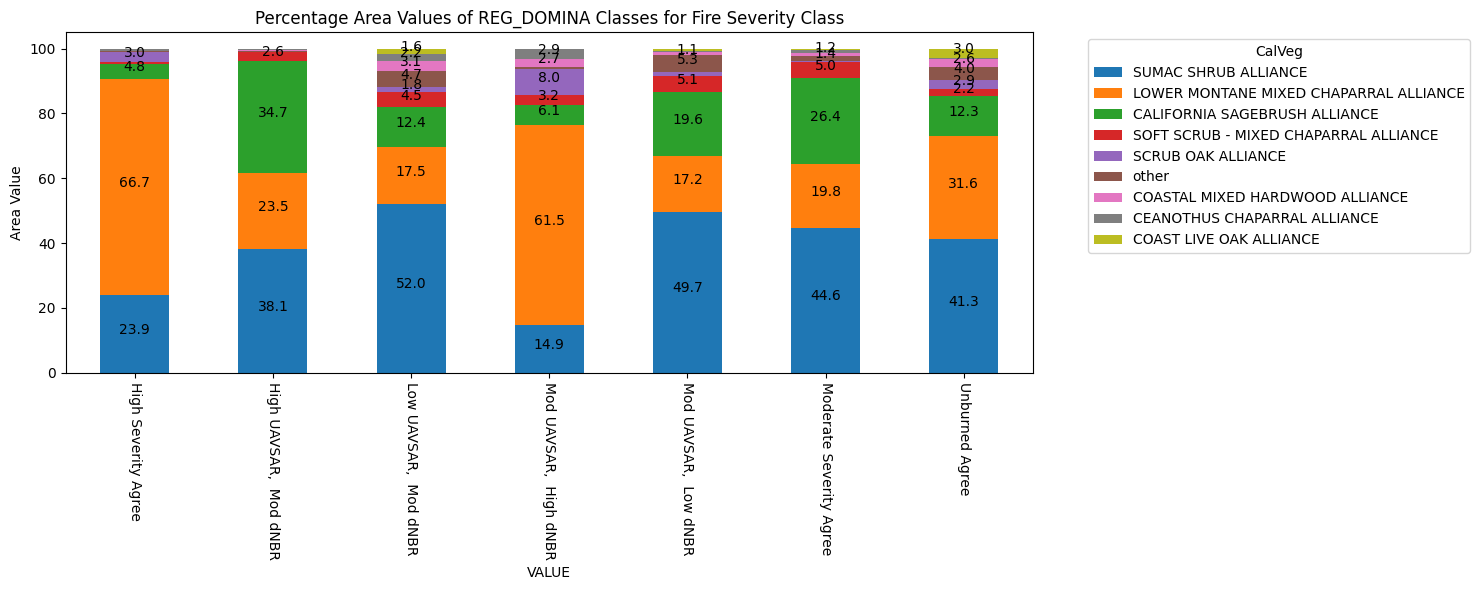

In [18]:
#@title CalVeg Bar Chart

# Define which REG_DOMINA categories to group into 'other'
other_categories = ['BUCKWHEAT ALLIANCE', 'Barren','ANNUAL GRASSES AND FORBS ALLIANCE', 'CALIFORNIA BAY ALLIANCE', 'URBAN-RELATED BARE SOIL', 'EUCALYPTUS ALLIANCE','BIGCONE DOUGLAS-FIR ALLIANCE']
                    #'SCRUB OAK ALLIANCE','CEANOTHUS CHAPARRAL ALLIANCE','COASTAL MIXED HARDWOOD ALLIANCE','SOFT SCRUB - MIXED CHAPARRAL ALLIANCE']  # categories to be grouped into 'other'

# Drop the original categories that were grouped into 'other'
grouped = grouped.drop(columns=other_categories)

# Group by VALUE and REG_DOMINA, then sum the percentage_overlap
grouped = df.groupby(['CLASS', 'REG_DOMINA'])['percentage_overlap'].sum().unstack()

# Create 'other' category by summing specified categories
grouped['other'] = grouped[other_categories].sum(axis=1)

# Drop the original categories that were grouped into 'other'
grouped = grouped.drop(columns=other_categories)

# Calculate the sum of percentage_overlap within each REG_DOMINA
sums_by_reg_domina = grouped.sum(axis=0)

# Sort the REG_DOMINA categories based on the sums
sorted_reg_domina = sums_by_reg_domina.sort_values(ascending=False).index

# Reindex the DataFrame based on the sorted REG_DOMINA categories
grouped_sorted = grouped[sorted_reg_domina]

# Plotting
ax = grouped_sorted.plot(kind='bar', stacked=True, figsize=(15, 6))

# Adding value labels on top of each bar (only if height > 1), comment out to get rid of labels
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 1:
        ax.annotate(f'{height:.1f}', (x + width/2, y + height*0.5), ha='center')

# Adding labels and title
plt.title('Percentage Area Values of REG_DOMINA Classes for Fire Severity Class')
plt.xlabel('VALUE')
plt.ylabel('Area Value')
plt.xticks(rotation=270)  # Rotate x-axis labels for better readability
# bigger legend - put outside plot
plt.legend(title='CalVeg', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

### CalVeg Composition for each Incidence Angle Range

In [19]:
# Read in incidence angle & make sure its the same projection
# Break the incidence angle array into masked_low, low, medium, high, masked_high
# Determine percentage overlap of the CalVeg classes per the "incidence angle classes" on the x-axis
# Do the same for 26526 & 08525

# Could be interesting to look at "Aspect"
# Read in the "Aspect" layer from the stack and classify into north-south
# Determine the percentage overlap of the CalVeg classes per the aspect classes on the x-axis

In [20]:
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/6m_stack.tif  --quiet

In [41]:
# Function to add a GeoTiff file
def read_file(file):
  stack = rio.open('6m_stack.tif')
  bands = stack.read((1,2,3,4,5,6,7,8,9))
  return bands

# Calling the function to read the file
stack = read_file('6m_stack.tif')

inc_08525 = stack[6, 0:, 0:]
inc_26526 = stack[7, 0:, 0:]
aspect = stack[8, 0:, 0:]

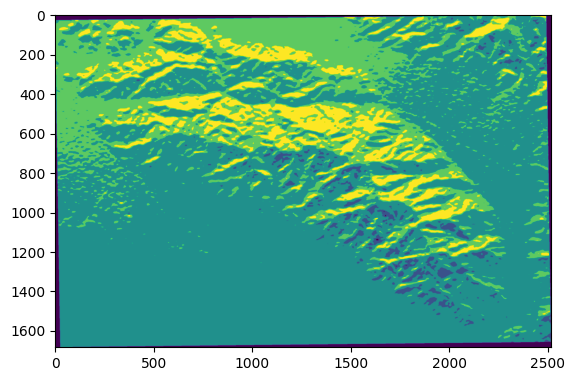

In [22]:
from shapely.geometry import Polygon
# Define angle ranges in radians
low_mask_threshold = 15 * np.pi / 180
low_threshold = 30 * np.pi / 180
medium_threshold = 55 * np.pi / 180
high_threshold = 70 * np.pi / 180

# Create masks
low_mask = inc_08525 < low_mask_threshold
low = (inc_08525 >= low_mask_threshold) & (inc_08525 < low_threshold)
medium = (inc_08525 >= low_threshold) & (inc_08525 < medium_threshold)
high = (inc_08525 >= medium_threshold) & (inc_08525 < high_threshold)
high_mask = inc_08525 >= high_threshold

# Combine masks to create a classified array
classified = np.zeros_like(inc_08525, dtype=np.uint8)
classified[low_mask] = 1
classified[low] = 2
classified[medium] = 3
classified[high] = 4
classified[high_mask] = 5

plt.imshow(classified)

In [23]:
classified_08525 = classified

# Write to TIFF
kwargs = rio.open('6m_stack.tif').meta
kwargs.update(
    dtype=rio.float32,
    count=1,
    compress='lzw')

with rio.open('classified_08525.tif', 'w', **kwargs) as dst:
    dst.write_band(1, classified_08525.astype(rio.float32))

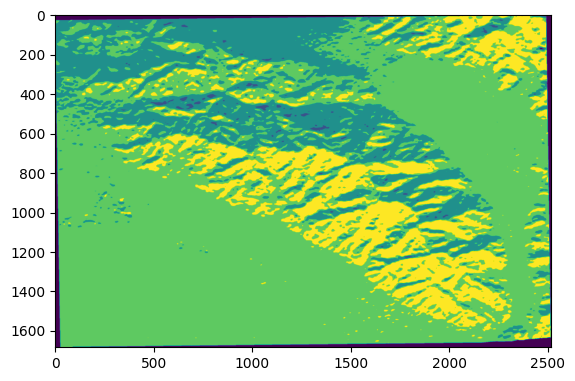

In [42]:
# Create masks
low_mask = inc_26526 < low_mask_threshold
low = (inc_26526 >= low_mask_threshold) & (inc_26526 < low_threshold)
medium = (inc_26526 >= low_threshold) & (inc_26526 < medium_threshold)
high = (inc_26526 >= medium_threshold) & (inc_26526 < high_threshold)
high_mask = inc_26526 >= high_threshold

# Combine masks to create a classified array
classified = np.zeros_like(inc_26526, dtype=np.uint8)
classified[low_mask] = 1
classified[low] = 2
classified[medium] = 3
classified[high] = 4
classified[high_mask] = 5

plt.imshow(classified)

In [65]:
classified_26526 = classified

# Write to TIFF
kwargs = rio.open('6m_stack.tif').meta
kwargs.update(
    dtype=rio.float32,
    count=1,
    compress='lzw')

with rio.open('classified_26526.tif', 'w', **kwargs) as dst:
    dst.write_band(1, classified_26526.astype(rio.float32))

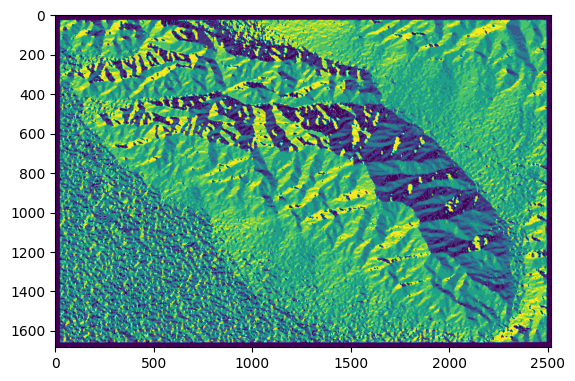

In [66]:
def classify_aspect_with_names(aspect):
    # thresholds
    north_low = 22.5
    east_low = 67.5
    east_high = 112.5
    south_low = 157.5
    south_high = 202.5
    west_low = 247.5
    west_high = 292.5
    north_high = 337.5

    # classify
    north = (aspect < north_low) | (aspect >= north_high)
    northeast = (aspect >= north_low) & (aspect < east_low)
    east = (aspect >= east_low) & (aspect < east_high)
    southeast = (aspect >= east_high) & (aspect < south_low)
    south = (aspect >= south_low) & (aspect < south_high)
    southwest = (aspect >= south_high) & (aspect < west_low)
    west = (aspect >= west_low) & (aspect < west_high)
    northwest = (aspect >= west_high) & (aspect < north_high)

    # classification array
    classified = np.zeros_like(aspect, dtype=np.uint8)
    classified[north] = 1
    classified[northeast] = 2
    classified[east] = 3
    classified[southeast] = 4
    classified[south] = 5
    classified[southwest] = 6
    classified[west] = 7
    classified[northwest] = 8

    return classified

classified_aspect = classify_aspect_with_names(aspect)
plt.imshow(classified_aspect)

# Write to TIFF
kwargs = rio.open('6m_stack.tif').meta
kwargs.update(
    dtype=rio.float32,
    count=1,
    compress='lzw')

with rio.open('classified_aspect.tif', 'w', **kwargs) as dst:
    dst.write_band(1, classified_aspect.astype(rio.float32))

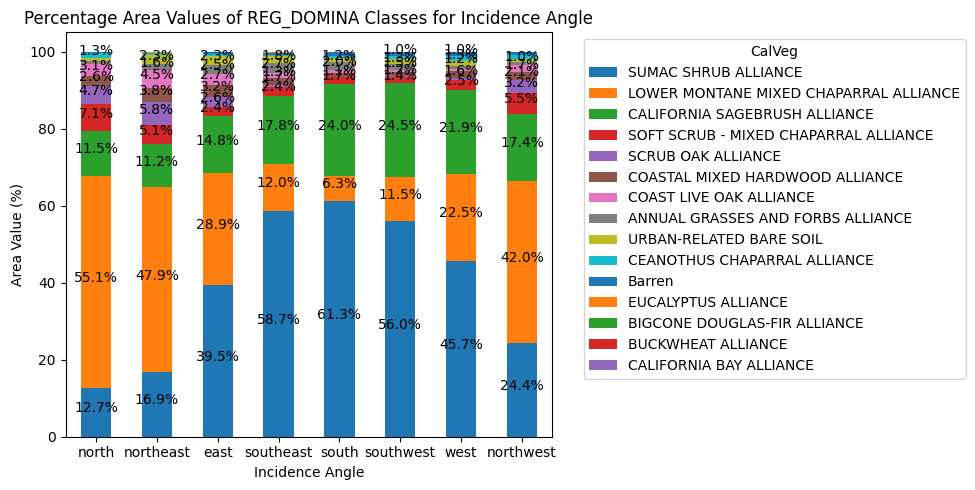

In [72]:
#@title Aspect & CalVeg
geojson1  = '/content/drive/MyDrive/UAVSAR_Science/LaTuna_Fire/Scripts/csvs/aspect_classified.geojson'
geojson2 = 'calveg_verdugos.geojson'

gdf1 = gpd.read_file(geojson1)
gdf2 = gpd.read_file(geojson2)

# Reproject geometries to a projected CRS
gdf1 = gdf1.to_crs('EPSG:3395')  # Choose an appropriate projected CRS
gdf2 = gdf2.to_crs('EPSG:3395')  # Choose the same CRS as gdf1

# Perform a spatial join to find overlapping geometries
intersected = gpd.overlay(gdf1, gdf2, how='intersection', keep_geom_type=False)

# Calculate the area of overlap for each attribute combination
intersected['overlap_area'] = intersected.geometry.area

# Calculate the total area of each attribute in gdf1
total_area_gdf1 = gdf1.groupby('VALUE')['geometry'].apply(lambda x: x.unary_union.area).reset_index()

# Calculate the percentage of overlap for each attribute combination
result = intersected.groupby(['VALUE', 'REG_DOMINA'])['overlap_area'].sum().reset_index()
total_area = result['overlap_area'].sum()

area_per_class = result.groupby('VALUE').sum()['overlap_area']
result = result.merge(area_per_class, left_on='VALUE', right_on='VALUE')
result['percentage_overlap'] = (result['overlap_area_x'] / result['overlap_area_y']) * 100

# Group by VALUE and REG_DOMINA, then sum the overlap_area
df = result
grouped = df.groupby(['VALUE', 'REG_DOMINA'])['percentage_overlap'].sum().unstack()

# Group by VALUE and REG_DOMINA, then sum the percentage_overlap
grouped = df.groupby(['VALUE', 'REG_DOMINA'])['percentage_overlap'].sum().unstack()

# Calculate the sum of percentage_overlap within each REG_DOMINA
sums_by_reg_domina = grouped.sum(axis=0)

# Sort the REG_DOMINA categories based on the sums
sorted_reg_domina = sums_by_reg_domina.sort_values(ascending=False).index

# Reindex the DataFrame based on the sorted REG_DOMINA categories
grouped_sorted = grouped[sorted_reg_domina]

# Plotting
ax = grouped_sorted.plot(kind='bar', stacked=True, figsize=(10, 5))

# Adding labels and title
plt.title('Percentage Area Values of REG_DOMINA Classes for Incidence Angle')
plt.xlabel('Incidence Angle')
plt.ylabel('Area Value (%)')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ["north", "northeast", "east", "southeast", "south", "southwest", "west", "northwest"]) # 10=High, 20=Moderate, 30=Low/Unburned
# bigger legend - put outside plot
plt.legend(title='CalVeg', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adding value labels on top of each bar (only if height > 1), comment out to get rid of labels
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 1:
        ax.annotate(f'{height:.1f}%', (x + width/2, y + height*0.5), ha='center')

# Show plot
plt.tight_layout()
plt.show()

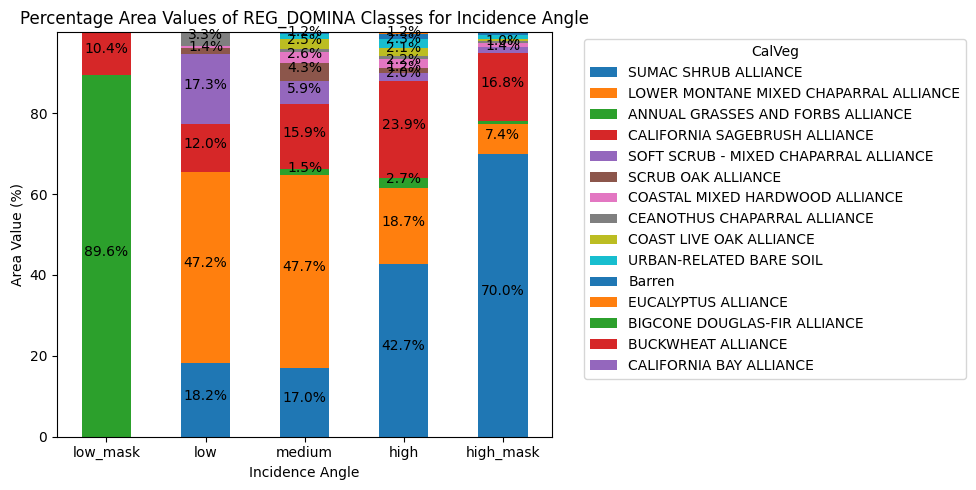

In [59]:
#@title Incidence Angle CalVeg Bar Chart (line 26526)
geojson1  = '/content/drive/MyDrive/UAVSAR_Science/LaTuna_Fire/Scripts/csvs/classified_inc_26526.geojson'
geojson2 = 'calveg_verdugos.geojson'

gdf1 = gpd.read_file(geojson1)
gdf2 = gpd.read_file(geojson2)

# Reproject geometries to a projected CRS
gdf1 = gdf1.to_crs('EPSG:3395')  # Choose an appropriate projected CRS
gdf2 = gdf2.to_crs('EPSG:3395')  # Choose the same CRS as gdf1

# Perform a spatial join to find overlapping geometries
intersected = gpd.overlay(gdf1, gdf2, how='intersection', keep_geom_type=False)

# Calculate the area of overlap for each attribute combination
intersected['overlap_area'] = intersected.geometry.area

# Calculate the total area of each attribute in gdf1
total_area_gdf1 = gdf1.groupby('VALUE')['geometry'].apply(lambda x: x.unary_union.area).reset_index()

# Calculate the percentage of overlap for each attribute combination
result = intersected.groupby(['VALUE', 'REG_DOMINA'])['overlap_area'].sum().reset_index()
total_area = result['overlap_area'].sum()

area_per_class = result.groupby('VALUE').sum()['overlap_area']
result = result.merge(area_per_class, left_on='VALUE', right_on='VALUE')
result['percentage_overlap'] = (result['overlap_area_x'] / result['overlap_area_y']) * 100

# Group by VALUE and REG_DOMINA, then sum the overlap_area
df = result
grouped = df.groupby(['VALUE', 'REG_DOMINA'])['percentage_overlap'].sum().unstack()

# Group by VALUE and REG_DOMINA, then sum the percentage_overlap
grouped = df.groupby(['VALUE', 'REG_DOMINA'])['percentage_overlap'].sum().unstack()

# Calculate the sum of percentage_overlap within each REG_DOMINA
sums_by_reg_domina = grouped.sum(axis=0)

# Sort the REG_DOMINA categories based on the sums
sorted_reg_domina = sums_by_reg_domina.sort_values(ascending=False).index

# Reindex the DataFrame based on the sorted REG_DOMINA categories
grouped_sorted = grouped[sorted_reg_domina]

# Plotting
ax = grouped_sorted.plot(kind='bar', stacked=True, figsize=(10, 5))

# Adding labels and title
plt.title('Percentage Area Values of REG_DOMINA Classes for Incidence Angle')
plt.xlabel('Incidence Angle')
plt.ylabel('Area Value (%)')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.xticks([0, 1, 2, 3, 4], ["low_mask", "low", "medium", "high", "high_mask"]) # 10=High, 20=Moderate, 30=Low/Unburned
# bigger legend - put outside plot
plt.legend(title='CalVeg', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adding value labels on top of each bar (only if height > 1), comment out to get rid of labels
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 1:
        ax.annotate(f'{height:.1f}%', (x + width/2, y + height*0.5), ha='center')

# Show plot
plt.tight_layout()
plt.show()

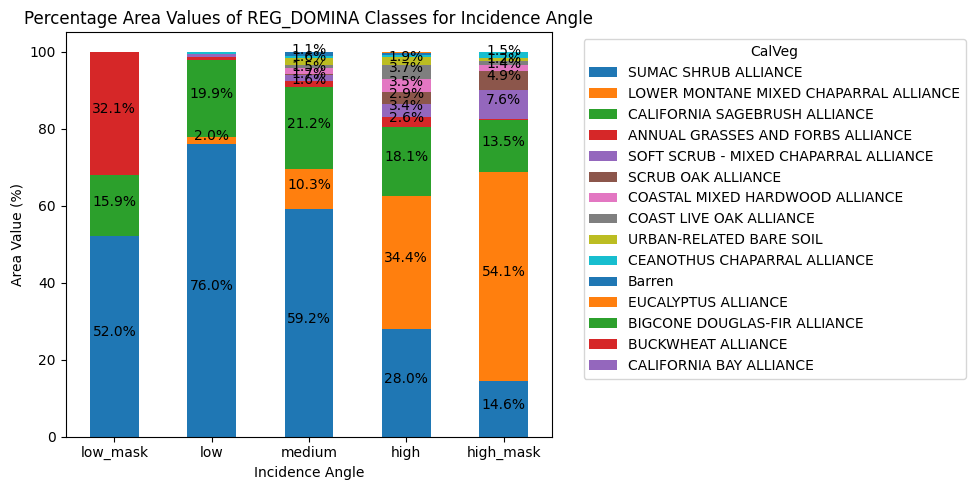

In [60]:
#@title Incidence Angle CalVeg Bar Chart (line 08525)
geojson1  = '/content/drive/MyDrive/UAVSAR_Science/LaTuna_Fire/Scripts/csvs/classified_inc_08525.geojson'
geojson2 = 'calveg_verdugos.geojson'

gdf1 = gpd.read_file(geojson1)
gdf2 = gpd.read_file(geojson2)

# Reproject geometries to a projected CRS
gdf1 = gdf1.to_crs('EPSG:3395')  # Choose an appropriate projected CRS
gdf2 = gdf2.to_crs('EPSG:3395')  # Choose the same CRS as gdf1

# Perform a spatial join to find overlapping geometries
intersected = gpd.overlay(gdf1, gdf2, how='intersection', keep_geom_type=False)

# Calculate the area of overlap for each attribute combination
intersected['overlap_area'] = intersected.geometry.area

# Calculate the total area of each attribute in gdf1
total_area_gdf1 = gdf1.groupby('VALUE')['geometry'].apply(lambda x: x.unary_union.area).reset_index()

# Calculate the percentage of overlap for each attribute combination
result = intersected.groupby(['VALUE', 'REG_DOMINA'])['overlap_area'].sum().reset_index()
total_area = result['overlap_area'].sum()

area_per_class = result.groupby('VALUE').sum()['overlap_area']
result = result.merge(area_per_class, left_on='VALUE', right_on='VALUE')
result['percentage_overlap'] = (result['overlap_area_x'] / result['overlap_area_y']) * 100

# Group by VALUE and REG_DOMINA, then sum the overlap_area
df = result
grouped = df.groupby(['VALUE', 'REG_DOMINA'])['percentage_overlap'].sum().unstack()

# Group by VALUE and REG_DOMINA, then sum the percentage_overlap
grouped = df.groupby(['VALUE', 'REG_DOMINA'])['percentage_overlap'].sum().unstack()

# Calculate the sum of percentage_overlap within each REG_DOMINA
sums_by_reg_domina = grouped.sum(axis=0)

# Sort the REG_DOMINA categories based on the sums
sorted_reg_domina = sums_by_reg_domina.sort_values(ascending=False).index

# Reindex the DataFrame based on the sorted REG_DOMINA categories
grouped_sorted = grouped[sorted_reg_domina]

# Plotting
ax = grouped_sorted.plot(kind='bar', stacked=True, figsize=(10, 5))

# Adding labels and title
plt.title('Percentage Area Values of REG_DOMINA Classes for Incidence Angle')
plt.xlabel('Incidence Angle')
plt.ylabel('Area Value (%)')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.xticks([0, 1, 2, 3, 4], ["low_mask", "low", "medium", "high", "high_mask"]) # 10=High, 20=Moderate, 30=Low/Unburned
# bigger legend - put outside plot
plt.legend(title='CalVeg', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adding value labels on top of each bar (only if height > 1), comment out to get rid of labels
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 1:
        ax.annotate(f'{height:.1f}%', (x + width/2, y + height*0.5), ha='center')

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
## Chart (NDVI for inc angle ranges, CalVeg for inc angle ranges, HV Log Ratio in inc angle ranges)

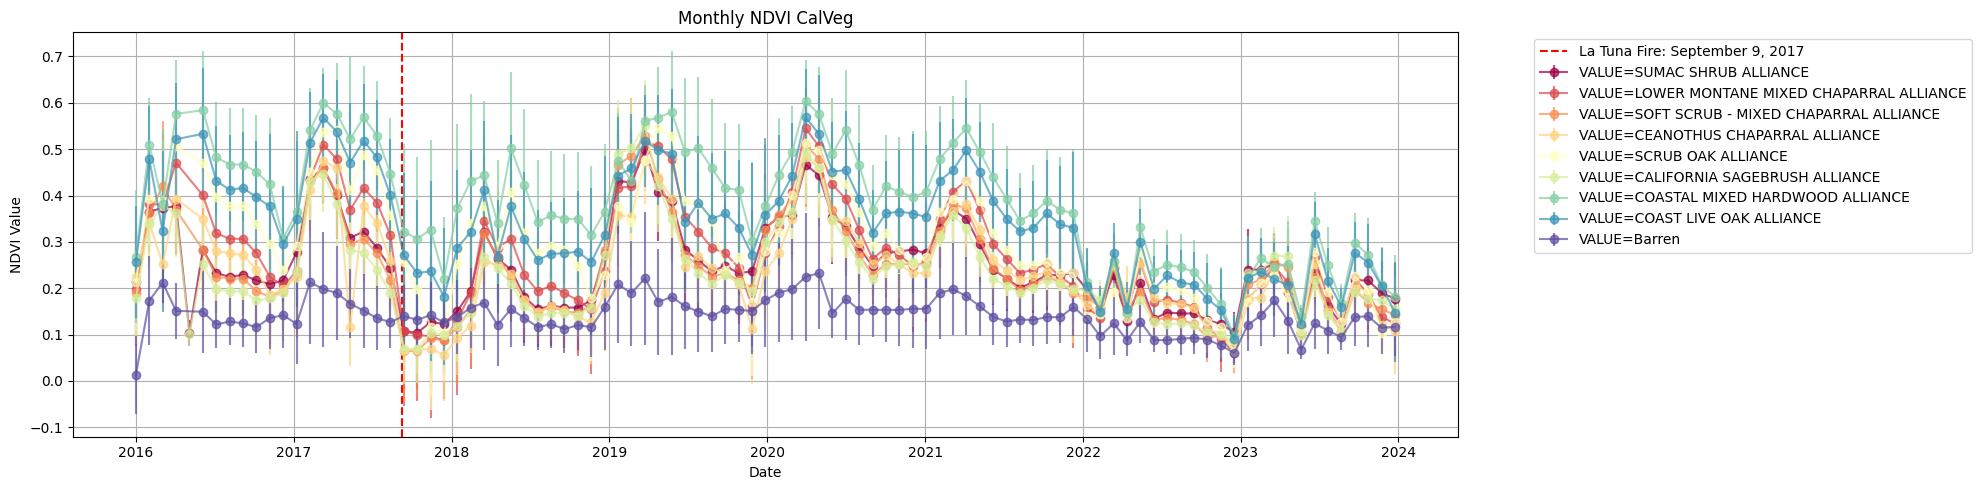

In [24]:
#@title CalVeg (all of Verdugos - not just burned. Veg composition may be changed post-fire)
df = calveg_df

# drop calveg classses that cover smaller areas (to make chart less busy)
df = df[df['VALUE'] != 'CALIFORNIA BAY ALLIANCE']
df = df[df['VALUE'] != 'BUCKWHEAT ALLIANCE']
df = df[df['VALUE'] != 'BIGCONE DOUGLAS-FIR ALLIANCE']
df = df[df['VALUE'] != 'EUCALYPTUS ALLIANCE']
df = df[df['VALUE'] != 'URBAN-RELATED BARE SOIL']
df = df[df['VALUE'] != 'ANNUAL GRASSES AND FORBS ALLIANCE']

df['date'] = pd.to_datetime(df['date'])


df['VALUE'] = df['VALUE']#.map(value_labels)

# Get unique values in the 'VALUE' column
unique_values = df['VALUE'].unique()

# Define colors for each unique value
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_values)))

# Plot all series on the same plot with different colors
plt.figure(figsize=(20, 5))
plt.axvline(pd.to_datetime('2017-09-09'), color='red', linestyle='--', label='La Tuna Fire: September 9, 2017')

for value, color in zip(unique_values, colors):
    df_value = df[df['VALUE'] == value]

    # check that df values are finite
    df_value = df_value[np.isfinite(df_value['NDVI']) & np.isfinite(df_value['STDEV'])]
    # check if df is not empty (getting error)
    if not df_value.empty:
        # Plot NDVI values with error bars
        plt.errorbar(df_value['date'], df_value['NDVI'], yerr=df_value['STDEV'], fmt='o', linestyle='-', alpha=0.7, color=color, label=f'VALUE={value}')

plt.title('Monthly NDVI CalVeg')
plt.xlabel('Date')
plt.ylabel('NDVI Value')
plt.grid(True)
plt.legend()

# bigger legend - put outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## NDVI Time Series

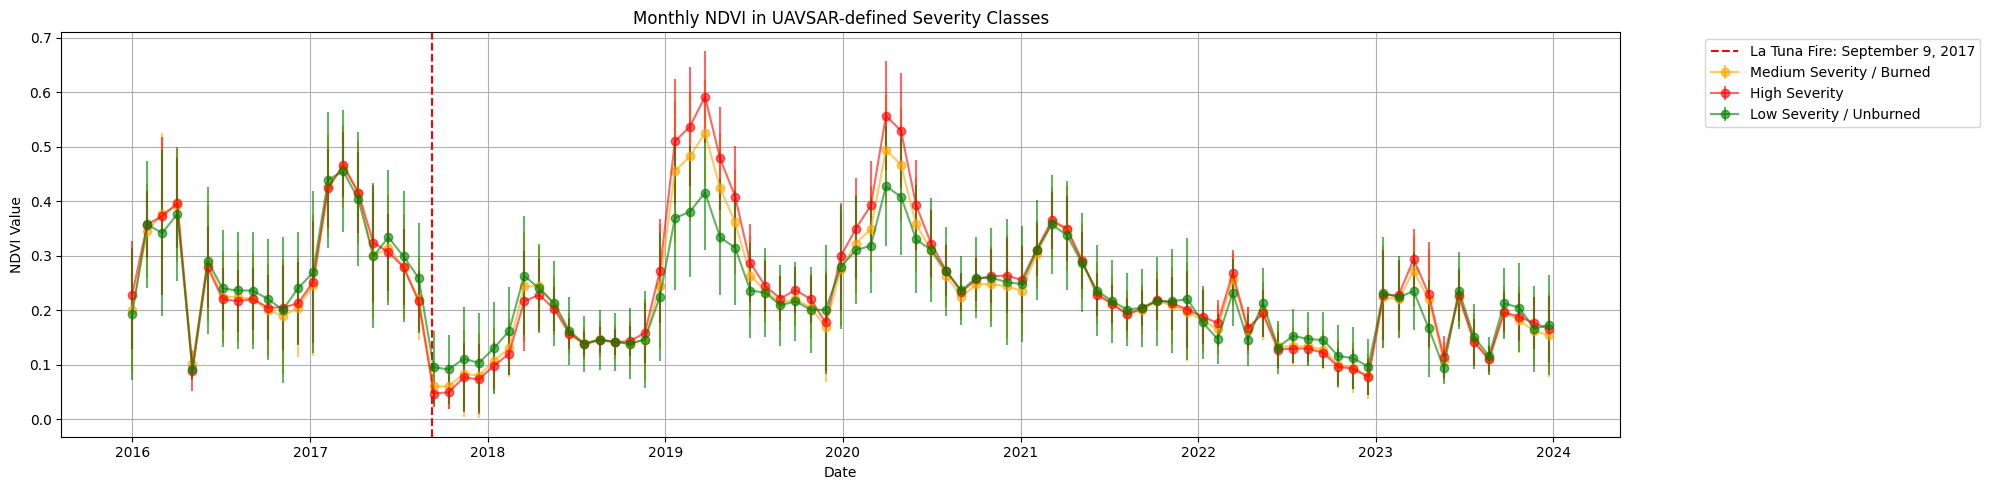

In [25]:
#@title Monthly NDVI (UAVSAR-defined Severity Classes)

df = uavsar_df.copy()

df['date'] = pd.to_datetime(df['date'])

# define value labels
value_labels = {
    10: 'Low Severity / Unburned',
    20: 'Medium Severity / Burned',
    30: 'High Severity'
}

# map the 'VALUE' column to its labels
df['VALUE'] = df['VALUE'].map(value_labels)

# get unique values in the 'VALUE' column
unique_values = df['VALUE'].unique()

# define specific colors for the unique values
color_map = {
    'Low Severity / Unburned': 'green',
    'Medium Severity / Burned': 'orange',
    'High Severity': 'red'
}

# plot all series on the same plot with different colors
plt.figure(figsize=(20, 5))
plt.axvline(pd.to_datetime('2017-09-09'), color='red', linestyle='--', label='La Tuna Fire: September 9, 2017')

for value in unique_values:
    df_value = df[df['VALUE'] == value]

    # filter out non-finite values (was getting an error for nan)
    df_value = df_value[np.isfinite(df_value['NDVI']) & np.isfinite(df_value['STDEV'])]

    if not df_value.empty:
        color = color_map.get(value)

        # Plot NDVI values with error bars
        plt.errorbar(df_value['date'], df_value['NDVI'], yerr=df_value['STDEV'], fmt='o', linestyle='-', alpha=0.6, color=color, label=value)

plt.title('Monthly NDVI in UAVSAR-defined Severity Classes')
plt.xlabel('Date')
plt.ylabel('NDVI Value')
plt.grid(True)

# place the legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

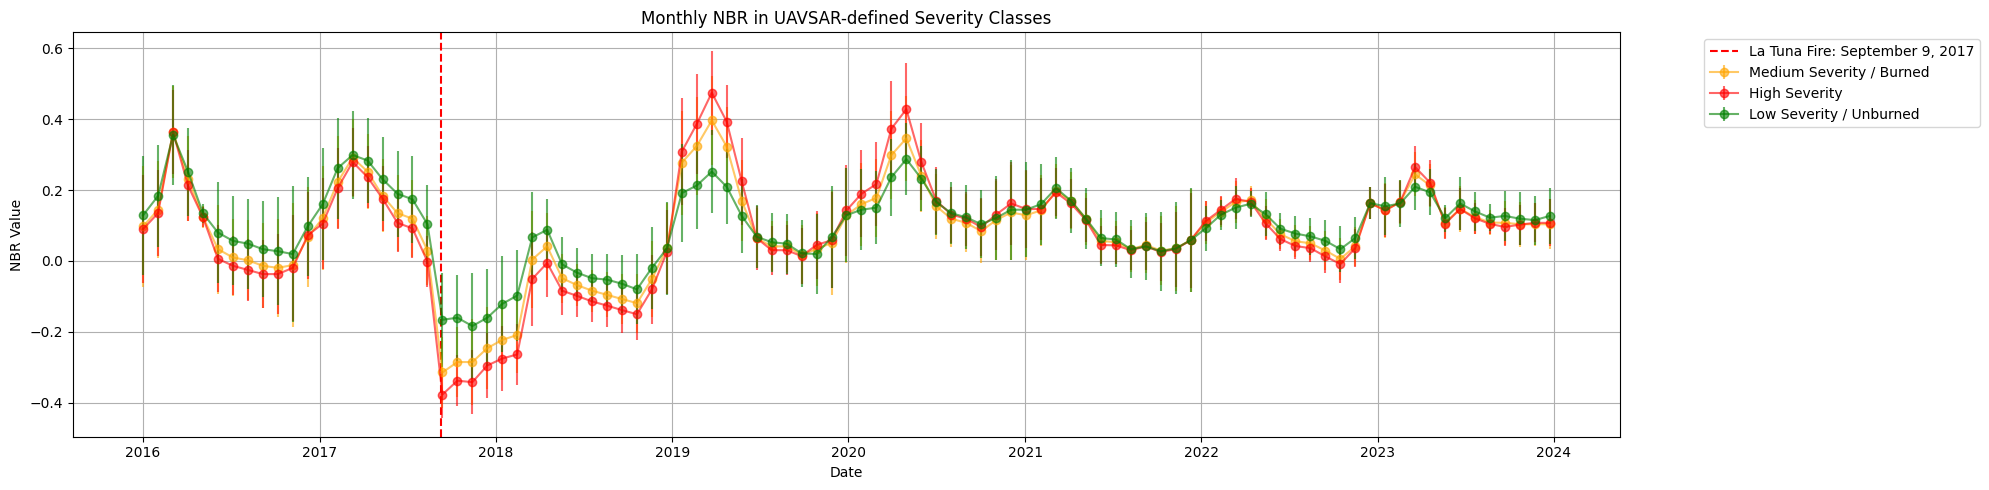

In [26]:
#@title Monthly NBR (UAVSAR-defined Severity Classes)
df = uavsar_df.copy()

df['date'] = pd.to_datetime(df['date'])

value_labels = {
    10: 'Low Severity / Unburned',
    20: 'Medium Severity / Burned',
    30: 'High Severity'
}

df['VALUE'] = df['VALUE'].map(value_labels)

# Get unique values in the 'VALUE' column
unique_values = df['VALUE'].unique()

# define specific colors for the unique values
color_map = {
    'Low Severity / Unburned': 'green',
    'Medium Severity / Burned': 'orange',
    'High Severity': 'red'
}

# Plot all series on the same plot with different colors
plt.figure(figsize=(20, 5))
plt.axvline(pd.to_datetime('2017-09-09'), color='red', linestyle='--', label='La Tuna Fire: September 9, 2017')


for value in unique_values:
    df_value = df[df['VALUE'] == value]

    # filter out non-finite values (was getting an error for nan)
    df_value = df_value[np.isfinite(df_value['NBR']) & np.isfinite(df_value['NBR_STDEV'])]

    if not df_value.empty:
        color = color_map.get(value)

        # Plot NDVI values with error bars
        plt.errorbar(df_value['date'], df_value['NBR'], yerr=df_value['NBR_STDEV'], fmt='o', linestyle='-', alpha=0.6, color=color, label=value)

plt.title('Monthly NBR in UAVSAR-defined Severity Classes')
plt.xlabel('Date')
plt.ylabel('NBR Value')
plt.grid(True)

# place the legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

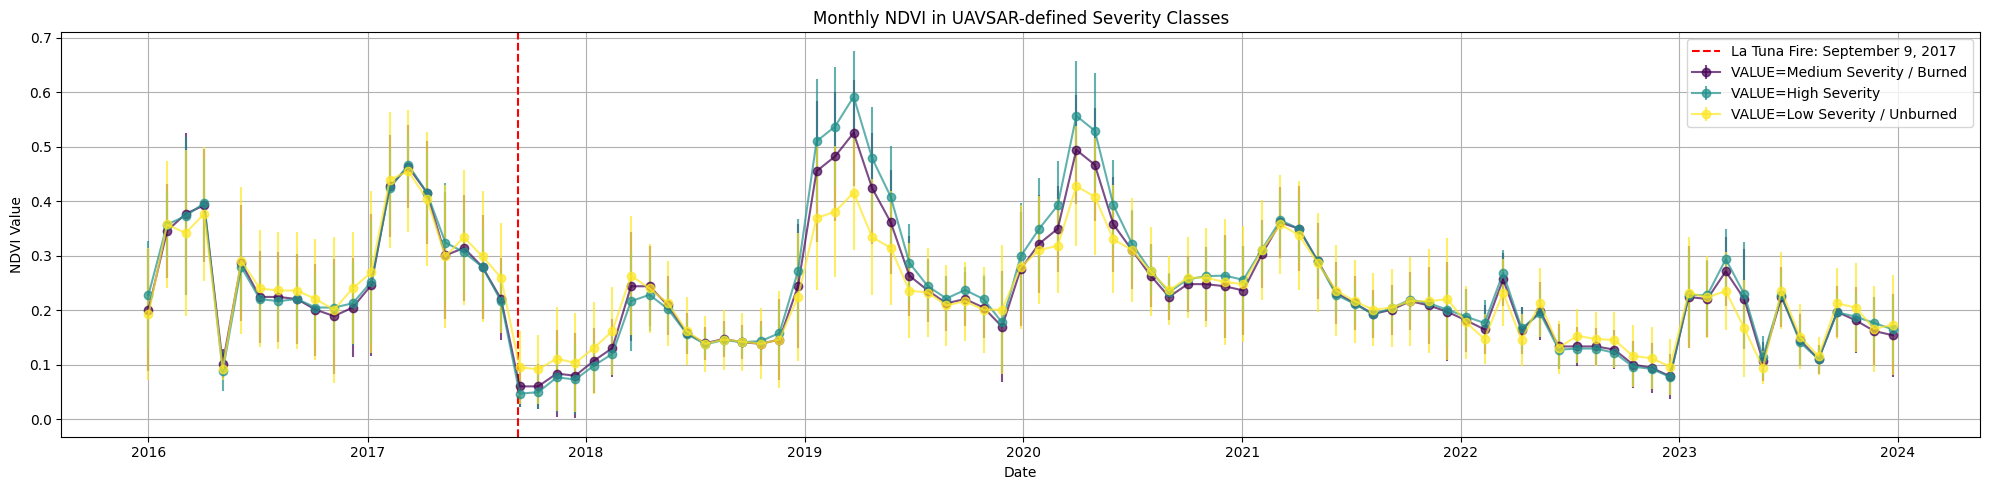

In [27]:
#@title Monthly NDVI (UAVSAR-defined Severity Classes)
df = uavsar_df

df['date'] = pd.to_datetime(df['date'])

value_labels = {
    10: 'Low Severity / Unburned',
    20: 'Medium Severity / Burned',
    30: 'High Severity'
}

df['VALUE'] = df['VALUE'].map(value_labels)

# Get unique values in the 'VALUE' column
unique_values = df['VALUE'].unique()

# Define colors for each unique value
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_values)))

# Plot all series on the same plot with different colors
plt.figure(figsize=(20, 5))
plt.axvline(pd.to_datetime('2017-09-09'), color='red', linestyle='--', label='La Tuna Fire: September 9, 2017')

for value, color in zip(unique_values, colors):
    # Select data for the current value
    df_value = df[df['VALUE'] == value]

    # Plot NDVI values with error bars
    plt.errorbar(df_value['date'], df_value['NDVI'], yerr=df_value['STDEV'], fmt='o', linestyle='-', alpha=0.7, color=color, label=f'VALUE={value}')

plt.title('Monthly NDVI in UAVSAR-defined Severity Classes')
plt.xlabel('Date')
plt.ylabel('NDVI Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
## Can generate interactive version of the charts below

#@title Monthly NDVI (UAVSAR-defined Severity Classes - interactive with plotly)
import plotly.graph_objs as go

df = uavsar_df

# Define colors for each unique value
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_values)))

# Convert colors to hex format
hex_colors = ['#%02x%02x%02x' % tuple(int(255 * c) for c in color[:3]) for color in colors]

# Create traces for each series
traces = []
for value, hex_color in zip(unique_values, hex_colors):
    trace = go.Scatter(x=df[df['VALUE'] == value]['date'], y=df[df['VALUE'] == value]['NDVI'], mode='lines+markers', name=f'VALUE={value}', line=dict(color=hex_color))
    traces.append(trace)

# Add vertical line for La Tuna Fire
la_tuna_fire_line = go.Scatter(x=[pd.to_datetime('2017-09-09'), pd.to_datetime('2017-09-09')],
                               y=[df['NDVI'].min(), df['NDVI'].max()],
                               mode='lines',
                               name='La Tuna Fire: September 9, 2017',
                               line=dict(color='red', dash='dash'))

# Create layout
layout = go.Layout(title='Monthly NDVI in UAVSAR-defined Severity Classes',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='NDVI Value'),
                   legend=dict(x=0, y=1, traceorder='normal'))

# Plot
fig = go.Figure(data=traces + [la_tuna_fire_line], layout=layout)
fig.show()


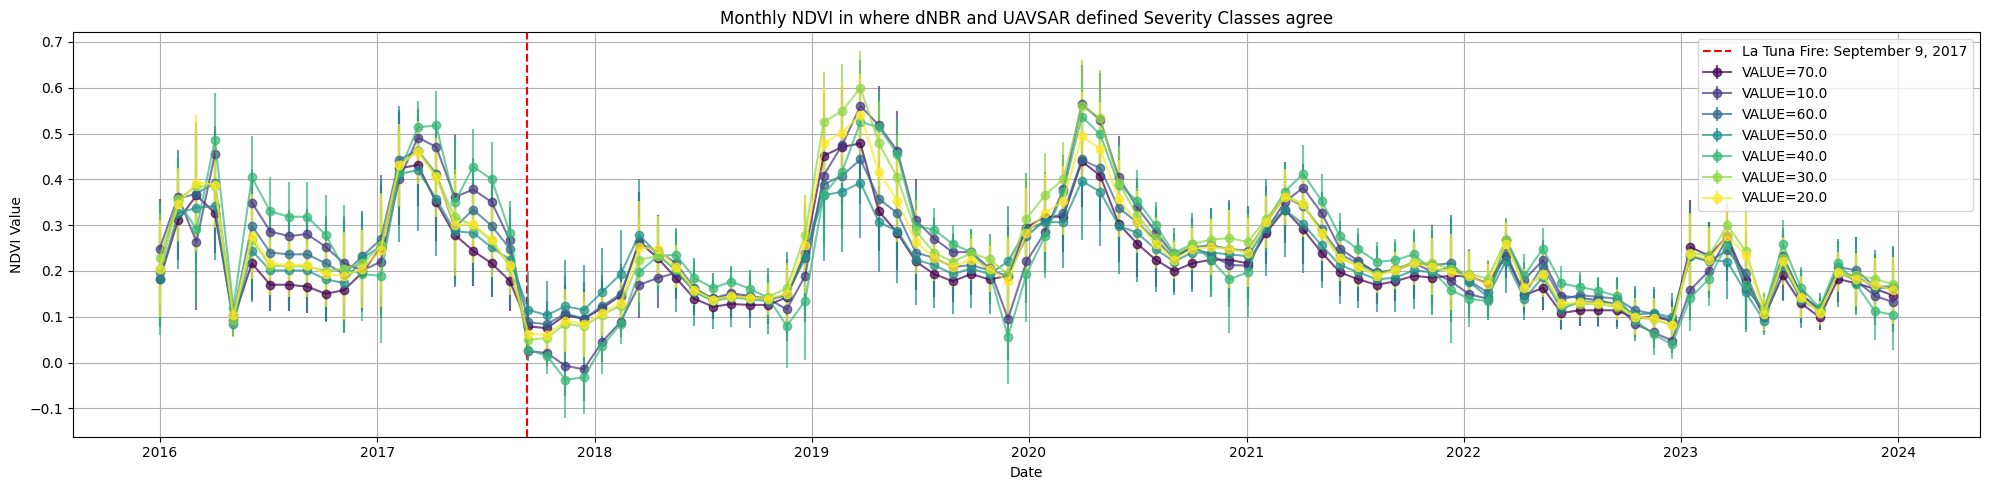

In [29]:
#@title Monthly NDVI (UAVSAR & dNBR comparison classes)

df = dnbr_uavsar_agree_df
df['date'] = pd.to_datetime(df['date'])

# value_labels = {
#     10: 'Low Severity / Unburned',
#     20: 'Medium Severity / Burned',
#     30: 'High Severity'
# }

# df['VALUE'] = df['VALUE'].map(value_labels)

# Get unique values in the 'VALUE' column
unique_values = df['VALUE'].unique()

# Define colors for each unique value
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_values)))

# Plot all series on the same plot with different colors
plt.figure(figsize=(20, 5))
plt.axvline(pd.to_datetime('2017-09-09'), color='red', linestyle='--', label='La Tuna Fire: September 9, 2017')

for value, color in zip(unique_values, colors):
    # Select data for the current value
    df_value = df[df['VALUE'] == value]

    # Plot NDVI values with error bars
    plt.errorbar(df_value['date'], df_value['NDVI'], yerr=df_value['STDEV'], fmt='o', linestyle='-', alpha=0.7, color=color, label=f'VALUE={value}')

plt.title('Monthly NDVI in where dNBR and UAVSAR defined Severity Classes agree')
plt.xlabel('Date')
plt.ylabel('NDVI Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

<ipython-input-30-6ea46ea71242>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



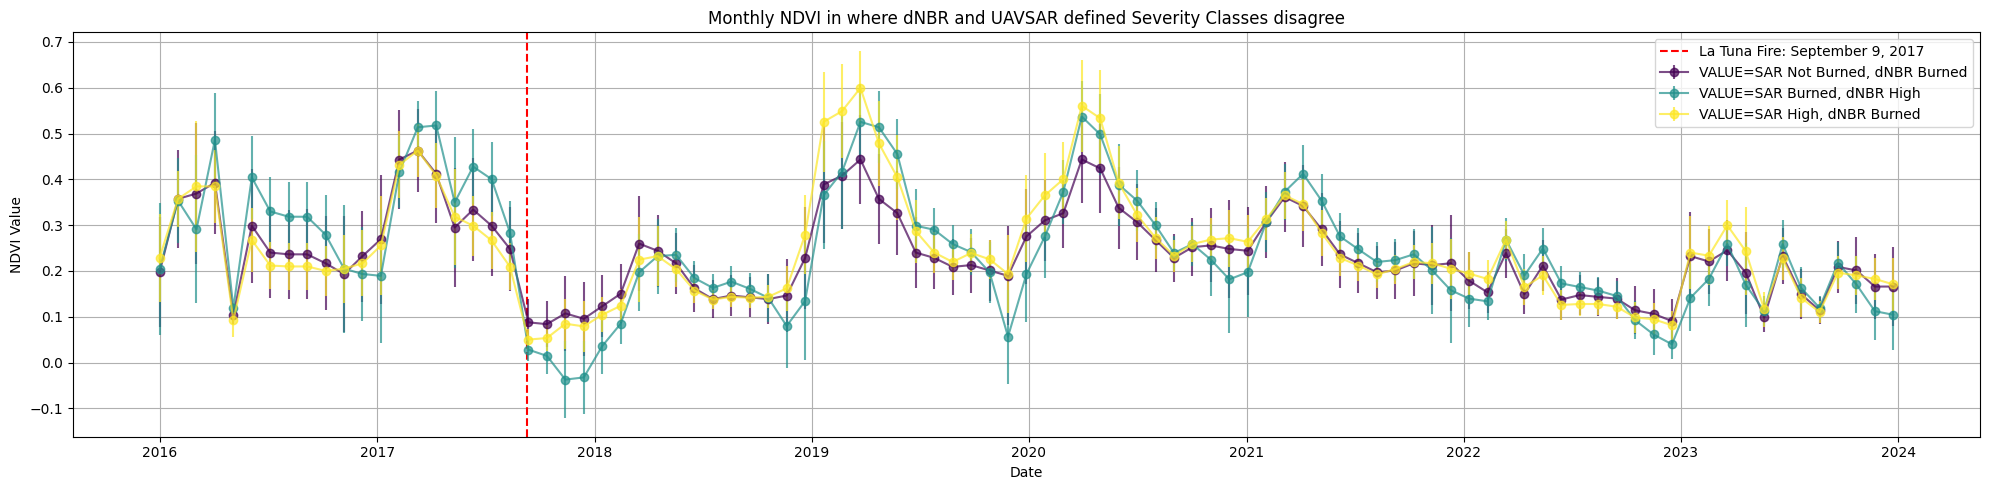

In [30]:
#@title Monthly NDVI (UAVSAR & dNBR disagree classes)

df = dnbr_uavsar_disagree_df
df['date'] = pd.to_datetime(df['date'])

df = df[df['VALUE'] != 10]

value_labels = {
    #10: 'High Agree',
    60: 'SAR Not Burned, dNBR Burned',
    40: 'SAR Burned, dNBR High',
    30: 'SAR High, dNBR Burned'
}

df['VALUE'] = df['VALUE'].map(value_labels)

# Get unique values in the 'VALUE' column
unique_values = df['VALUE'].unique()

# Define colors for each unique value
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_values)))

# Plot all series on the same plot with different colors
plt.figure(figsize=(20, 5))
plt.axvline(pd.to_datetime('2017-09-09'), color='red', linestyle='--', label='La Tuna Fire: September 9, 2017')

for value, color in zip(unique_values, colors):
    # Select data for the current value
    df_value = df[df['VALUE'] == value]

    # Plot NDVI values with error bars
    plt.errorbar(df_value['date'], df_value['NDVI'], yerr=df_value['STDEV'], fmt='o', linestyle='-', alpha=0.7, color=color, label=f'VALUE={value}')

plt.title('Monthly NDVI in where dNBR and UAVSAR defined Severity Classes disagree')
plt.xlabel('Date')
plt.ylabel('NDVI Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

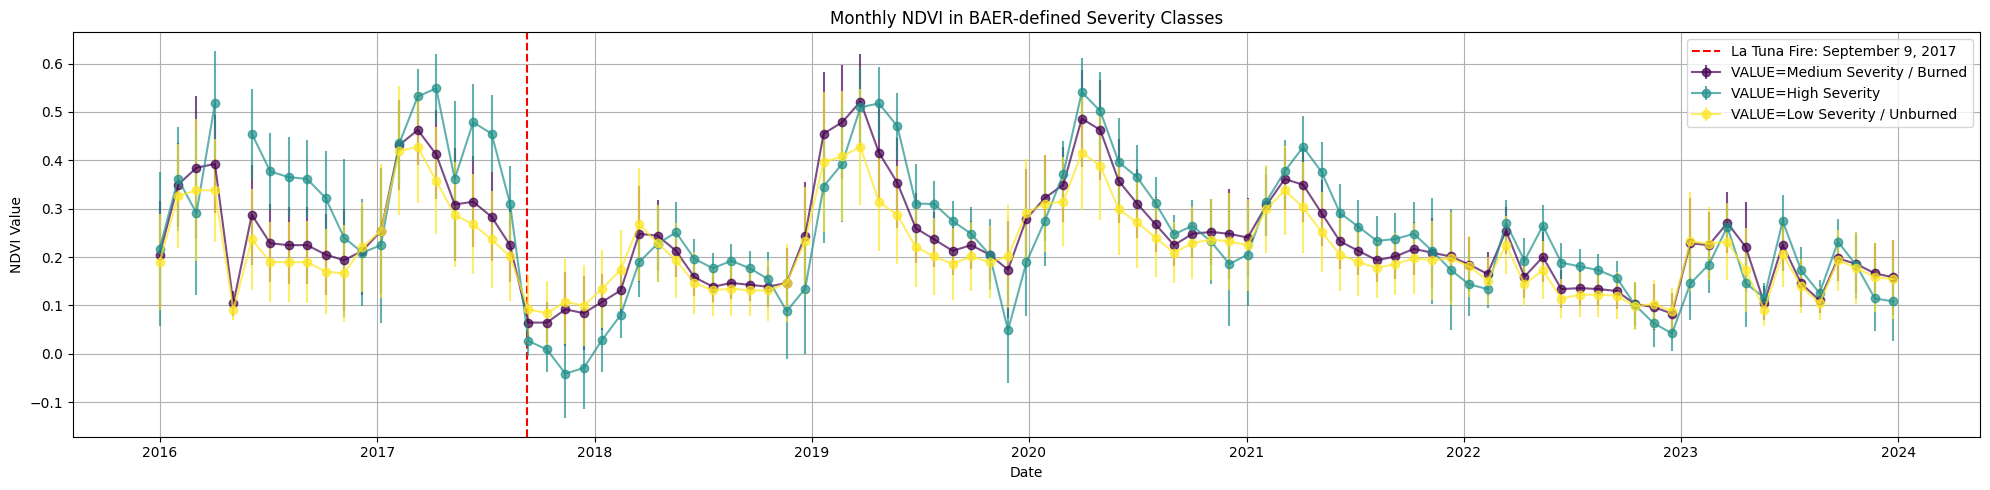

In [31]:
#@title Monthly NDVI (BARC-defined Severity Classes)

df = baer_df
df['date'] = pd.to_datetime(df['date'])

value_labels = {
    2: 'Low Severity / Unburned',
    3: 'Medium Severity / Burned',
    4: 'High Severity'
}

df['VALUE'] = df['VALUE'].map(value_labels)

# Get unique values in the 'VALUE' column
unique_values = df['VALUE'].unique()

# Define colors for each unique value
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_values)))

# Plot all series on the same plot with different colors
plt.figure(figsize=(20, 5))
plt.axvline(pd.to_datetime('2017-09-09'), color='red', linestyle='--', label='La Tuna Fire: September 9, 2017')

for value, color in zip(unique_values, colors):
    # Select data for the current value
    df_value = df[df['VALUE'] == value]

    # Plot NDVI values with error bars
    plt.errorbar(df_value['date'], df_value['NDVI'], yerr=df_value['STDEV'], fmt='o', linestyle='-', alpha=0.7, color=color, label=f'VALUE={value}')

plt.title('Monthly NDVI in BAER-defined Severity Classes')
plt.xlabel('Date')
plt.ylabel('NDVI Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

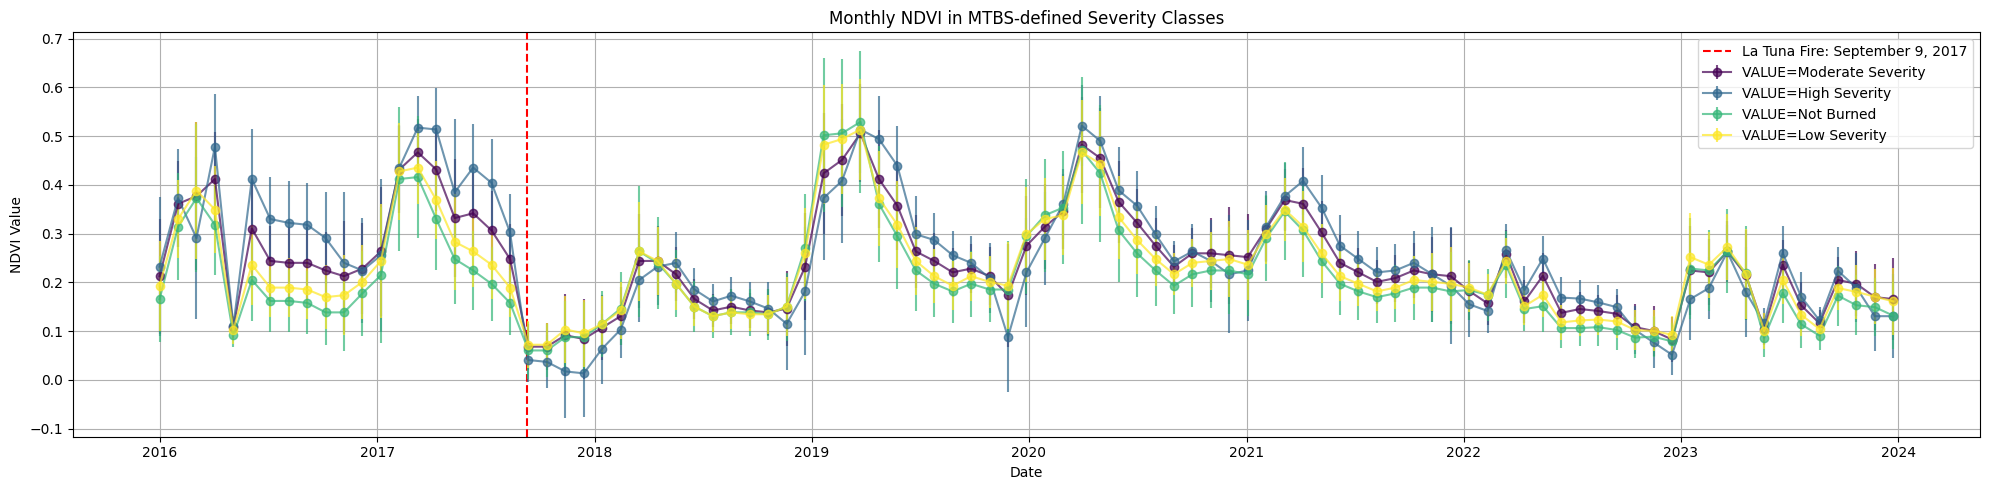

In [32]:
#@title Monthly NDVI (MTBS-defined Severity Classes)

df = mtbs_df
df['date'] = pd.to_datetime(df['date'])

value_labels = {
    1: 'Not Burned',
    2: 'Low Severity',
    3: 'Moderate Severity',
    4: 'High Severity'
}

df['VALUE'] = df['VALUE'].map(value_labels)

# Get unique values in the 'VALUE' column
unique_values = df['VALUE'].unique()

# Define colors for each unique value
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_values)))

# Plot all series on the same plot with different colors
plt.figure(figsize=(20, 5))
plt.axvline(pd.to_datetime('2017-09-09'), color='red', linestyle='--', label='La Tuna Fire: September 9, 2017')

for value, color in zip(unique_values, colors):
    # Select data for the current value
    df_value = df[df['VALUE'] == value]

    # Plot NDVI values with error bars
    plt.errorbar(df_value['date'], df_value['NDVI'], yerr=df_value['STDEV'], fmt='o', linestyle='-', alpha=0.7, color=color, label=f'VALUE={value}')

plt.title('Monthly NDVI in MTBS-defined Severity Classes')
plt.xlabel('Date')
plt.ylabel('NDVI Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Landsat Time Series